In [1]:
#Modules for executing steps of Notebook
import acquire
import explore

In [2]:
import pandas

In [29]:
#Plotting libraries
import warnings
from pandas import read_csv
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from pylab import rcParams

#Style-settings for Notebook
rcParams['figure.figsize'] = 18, 8
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

In [4]:
#Statistic tools for plots and for scoring
from statsmodels.tsa.seasonal import seasonal_decompose

## ACQUIRE/PREP

Acquire the data from the online source at https://ds.codeup.com/fitbit-data.tar.gz

In [5]:
df = acquire.get_data()

In [9]:
len(df)

225

In [6]:
df.Date.nunique()

225

Df2 is the prepared data, with no nulls and with all dtypes are numerical

In [7]:
df2 = acquire.clean_data(df)

In [8]:
df2.tail()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-12-02,3957.0,13257.0,6.23,195,725.0,265,13,70,2305.0
2018-12-03,3660.0,12915.0,6.12,6,782.0,219,40,51,1993.0
2018-12-04,3384.0,13763.0,6.49,13,608.0,199,11,67,1663.0
2018-12-05,3670.0,13865.0,6.52,12,739.0,200,12,69,1968.0
2018-12-06,3669.0,14774.0,6.96,9,647.0,198,4,78,1962.0


Scaled DataFrame if need be

In [10]:
scaled_df = acquire.scale_data(df2)
scaled_df = scaled_df.set_index(df2.index)

# EXPLORE

#### Bird's Eye View of the Dataset

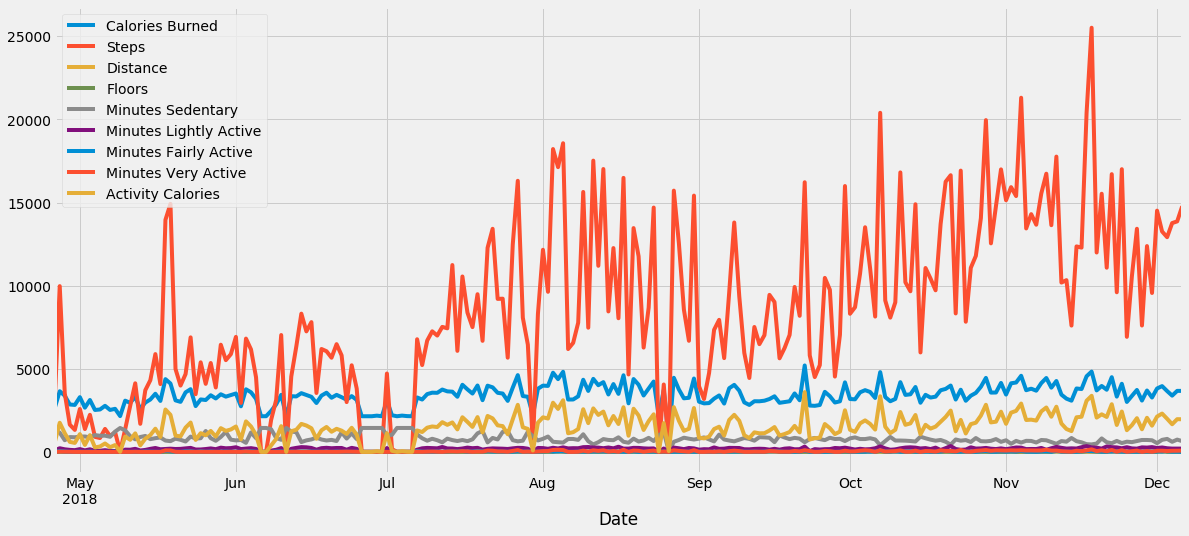

In [31]:
df2.plot()
plt.show()

#### Bird's Eye View of the Dataset, without Steps column

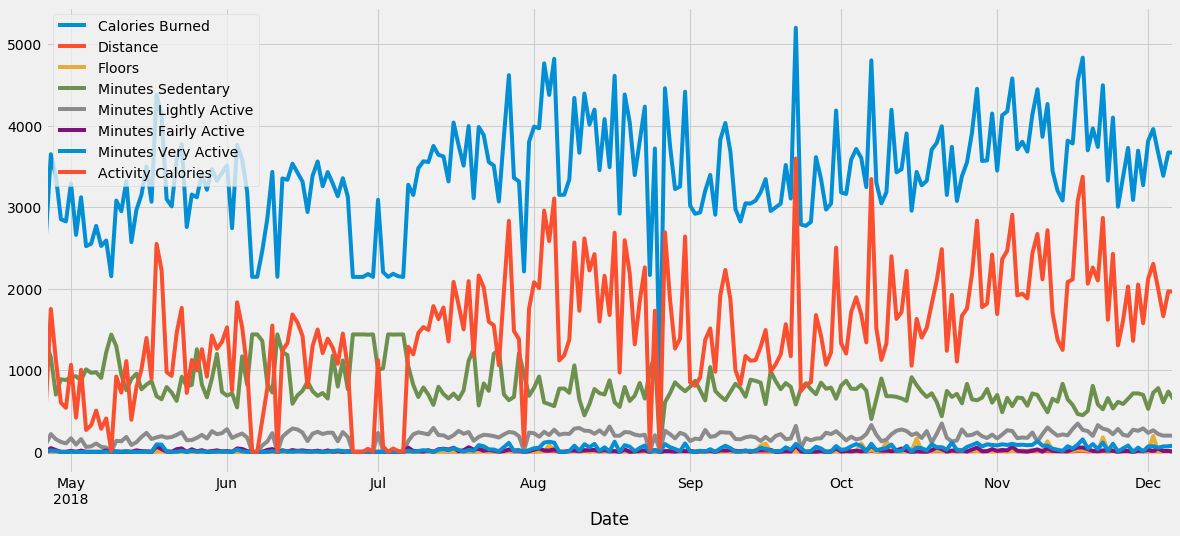

In [12]:
df2.drop('Steps',axis=1).plot()
plt.show()

#### Bird's Eye View of the Dataset

#### With scaled data

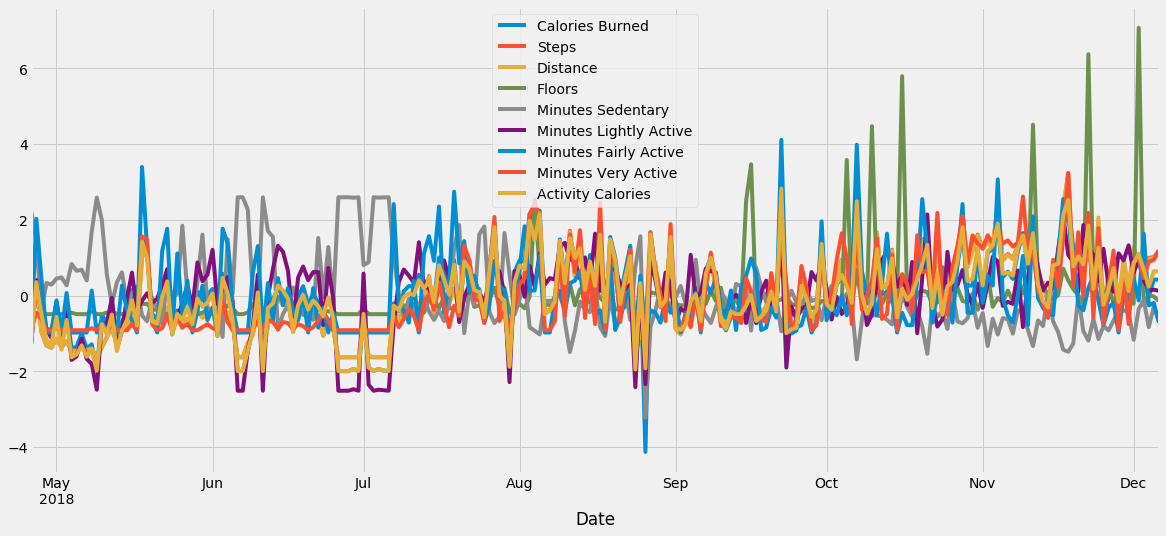

In [13]:
scaled_df.plot()
plt.show()

### The day of the EVENT

In [14]:
date_of_event = '2018-07-01'

In [15]:
event_range = scaled_df['2018-05':'2018-08']

2 months before and after The Event

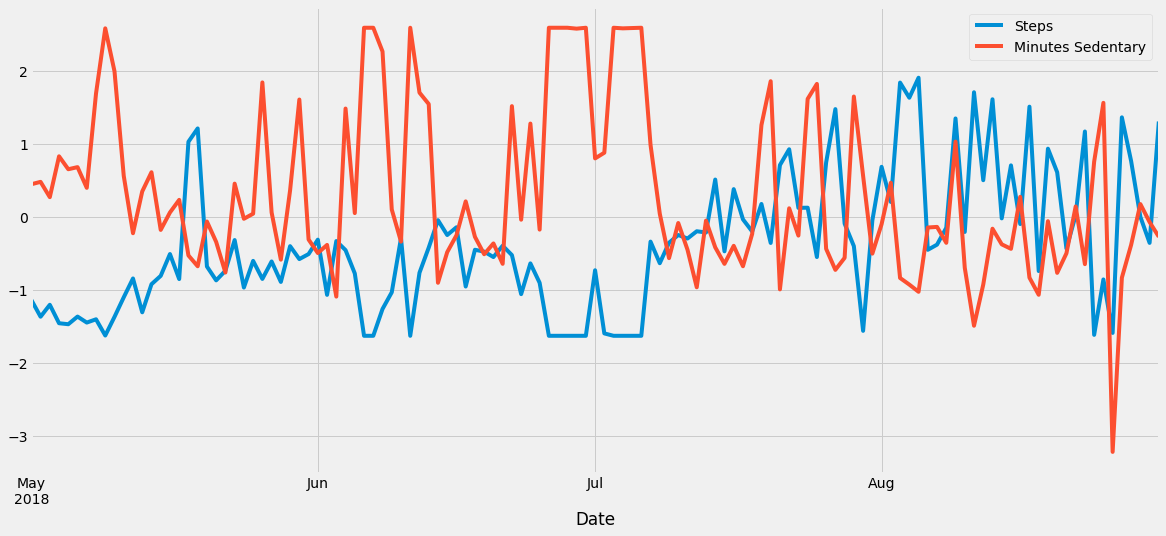

In [16]:
event_range[['Steps','Minutes Sedentary']].plot()

In [17]:
#Splitting the time into before and after the speculated event
pre_event = df2[:date_of_event]
post_event = df2[date_of_event:]

In [18]:
#This will be for testing/plotting purposes in a later section
pre_event_with_room = df2[:'2018-08-01']

## Before the event

In [19]:
pre_event.describe()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,3047.820896,4064.955224,1.917164,2.492537,962.880597,152.134328,10.895522,6.223881,954.597015
std,510.418899,3067.709329,1.446857,3.726942,268.292949,82.320677,14.360230,15.878154,581.841332
min,2144.000000,0.000000,0.000000,0.000000,545.000000,0.000000,0.000000,0.000000,0.000000
25%,2701.000000,1511.000000,0.710000,0.000000,746.500000,98.000000,0.000000,0.000000,523.000000
50%,3127.000000,3989.000000,1.880000,1.000000,891.000000,171.000000,5.000000,1.000000,1011.000000
75%,3396.000000,5880.500000,2.770000,3.000000,1182.500000,221.500000,18.000000,6.500000,1368.500000
max,4376.000000,14917.000000,7.040000,19.000000,1440.000000,287.000000,67.000000,92.000000,2549.000000


## After the event

In [23]:
post_event.describe()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,3549.157233,10396.251572,4.932704,16.792453,746.125786,203.723270,16.522013,45.308176,1705.597484
std,619.546971,4833.587821,2.310583,29.674623,200.078711,66.318746,15.506567,37.518763,695.647118
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000
25%,3157.000000,7038.500000,3.320000,6.000000,634.000000,172.000000,6.000000,11.000000,1276.500000
50%,3553.000000,9719.000000,4.580000,9.000000,716.000000,210.000000,13.000000,42.000000,1684.000000
75%,3936.000000,13780.500000,6.595000,16.000000,816.000000,242.500000,22.500000,76.500000,2114.500000
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,349.000000,78.000000,154.000000,3596.000000


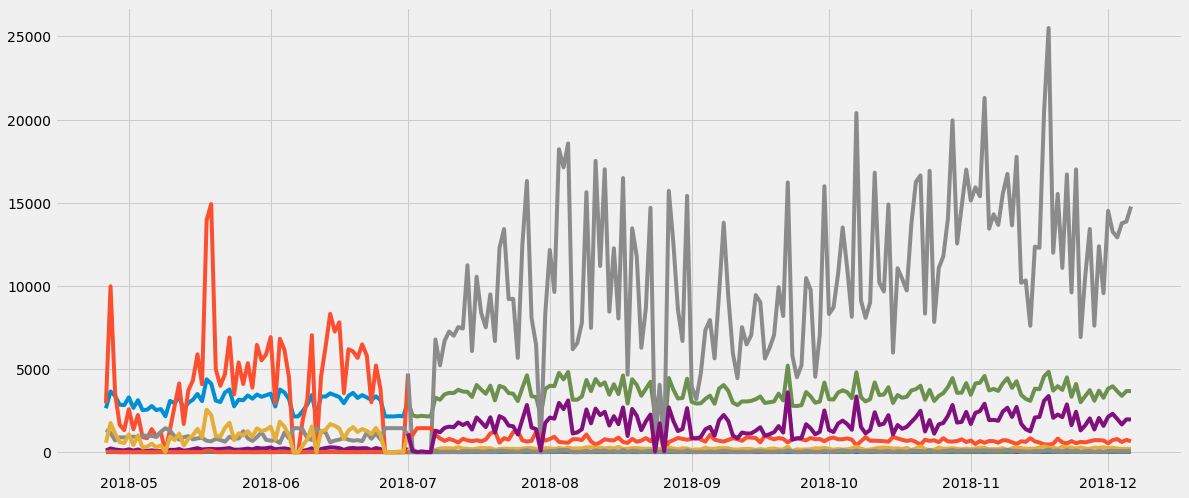

In [32]:
plt.plot(pre_event)
plt.plot(post_event)
plt.show()

    Why the outlier spikes in floors column?

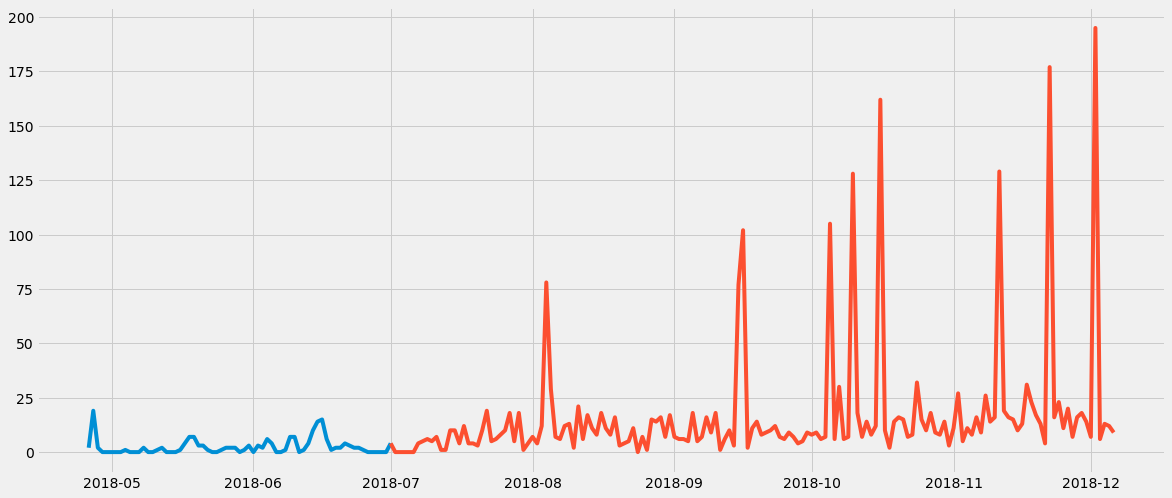

In [25]:
plt.pyplot.plot(pre_event.Floors)
plt.pyplot.plot(post_event.Floors)
plt.pyplot.show()

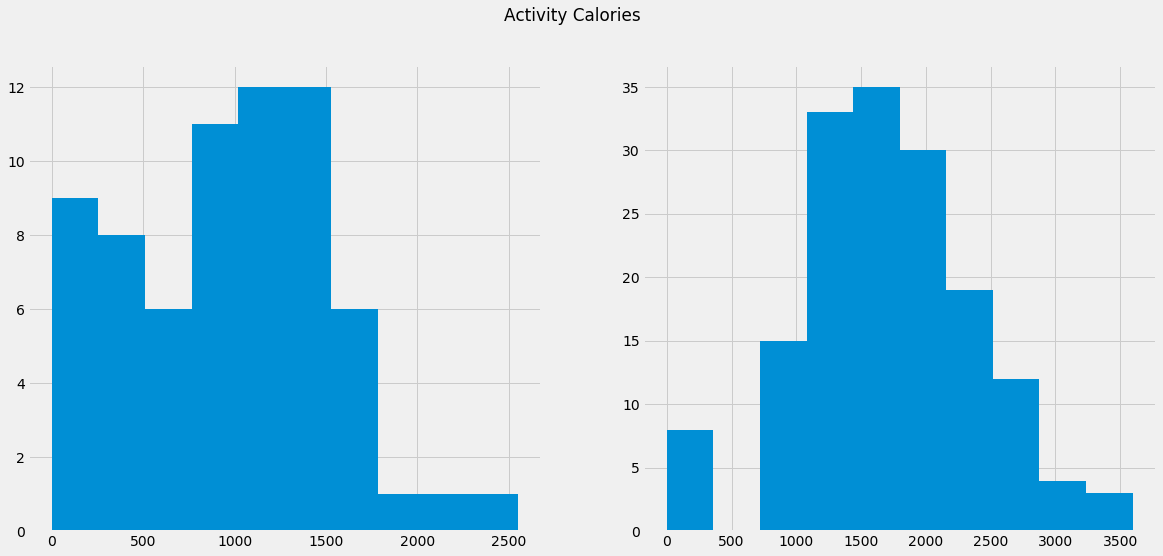

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Activity Calories')
ax1.hist(pre_event['Activity Calories'])
ax2.hist(post_event['Activity Calories'])
plt.show()

## Decomposition
### Are trends consitent throughout the timeline?

In [ ]:
#The steps is very out of range from the rest of the columns. It's dropped for visual purposes.
all_time = seasonal_decompose(df2.drop('Steps',axis=1), model='additive')

    There looks to be a change in the trend starting at the end of June

In [ ]:
all_time.plot()
plt.pyplot.show()

    Steps has a demonstrable change in trend after The Event

In [ ]:
just_steps = seasonal_decompose(df2.Steps, model='additive')

In [ ]:
sedentary = seasonal_decompose(df2['Minutes Sedentary'], model='additive')

In [ ]:
just_steps.trend.plot()
plt.pyplot.show()

In [ ]:
sedentary.trend.plot()
plt.pyplot.show()

Pre-Event

    There is not much change in seasonlity effects or amount of noise before and after The Event.

In [ ]:
result = seasonal_decompose(pre_event.drop('Steps',axis=1), model='additive')

In [ ]:
result.plot()
plt.pyplot.show()

Post-Event

    The mean of most columns increase and their variance decreases.

In [ ]:
result2 = seasonal_decompose(post_event.drop('Steps',axis=1), model='additive')

In [ ]:
result2.plot()
plt.pyplot.show()

In [ ]:
scaled_results = seasonal_decompose(scaled_df.drop('Steps',axis=1), model='additive')

In [ ]:
#NO BUENO
scaled_results.plot()
plt.pyplot.show()

# FORECASTING

### ARIMA model
#### Predicting the 4 Weeks After the End of the Dataset, using all of the dataset
    Activity Calories

In [ ]:
explore.time_predict(df2,'Activity Calories',forecast=True, step_count=28)
plt.pyplot.show()

In [ ]:
explore.time_predict(df2,'Activity Calories',stats_info=True, step_count=28)

In [ ]:
explore.time_predict(post_event,'Activity Calories',forecast=True, step_count=28)
plt.pyplot.show()

In [ ]:
explore.time_predict(post_event,'Activity Calories',stats_info=True, step_count=28)

    Calories Burned

In [ ]:
explore.time_predict(df2,'Calories Burned',forecast=True, step_count=28)
plt.pyplot.show()

In [ ]:
explore.time_predict(df2,'Calories Burned',stats_info=True, step_count=28)

In [ ]:
explore.time_predict(post_event,'Calories Burned',forecast=True, step_count=28)
plt.pyplot.show()

In [ ]:
explore.time_predict(post_event,'Calories Burned',stats_info=True, step_count=28)

#### Predicting the 2 Weeks After the Event

In [ ]:
df2.columns

# Conclusions

    Trends for several columns shifted upward after a negative spike around 01JUL2018
    
    The mean for several columns increased afte the spike
    
    Floors Coljmns had some very exorbitant outliers after this spike

In [ ]:
Add MSE to explore function
Try predict 2 weeks after EVent